# Mount Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Load libraries and set environment

In [1]:
%cd {'drive/MyDrive/DJIA'}

/content/drive/MyDrive/DJIA


In [2]:
%matplotlib inline
from pathlib import Path

# basic data manipuation
import pandas as pd
import numpy as np

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

# preprocessing
from sklearn.preprocessing import MinMaxScaler

# tensorflow utils for neural nets
import tensorflow as tf
import tensorflow.keras.backend as K

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, LSTM, Input, concatenate, Embedding, Reshape, BatchNormalization

from tensorflow import keras

# evaluation metrics
from sklearn.metrics import roc_auc_score
from scipy.stats import spearmanr

In [3]:
# install keras-tuner
!pip install -q -U keras-tuner

     |████████████████████████████████| 98 kB 5.5 MB/s 


In [4]:
# hyperparameter tuning bayesian optimization
import keras_tuner as kt
from keras_tuner.tuners import BayesianOptimization

If possible, use GPU, it will enable faster computation when performing optimization of parameters.

In [ ]:
# Check for gpu devices
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if gpu_devices:
    print('Using GPU')
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
else:
    print('Using CPU')

Using GPU


In [5]:
sns.set_style('whitegrid')
np.random.seed(123)

# Load Data

In [6]:
!pip install --upgrade -q tables
data = pd.read_hdf('data/ts_cl.h5', 'all_features')

     |████████████████████████████████| 5.9 MB 9.2 MB/s 


In [7]:
data.head()

,fwd_returns,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,topic_131,topic_132,topic_133,topic_134,topic_135,topic_136,topic_137,topic_138,topic_139,topic_140,topic_141,topic_142,topic_143,topic_144,topic_145,topic_146,topic_147,topic_148,topic_149,sent_0,sent_1,sent_2,sent_3,sent_4,sent_5,ind_0,ind_1,ind_2,ind_3,ind_4,ind_5,ind_6,ind_7,ind_8,ind_9,ind_10,ind_11,ind_12,ind_13,ind_14
2008-11-04,0.000294,0.004093,-0.011872,-0.009406,0.007194,0.003785,-0.015481,-0.011398,0.006069,0.001119,0.017309,-0.020795,0.002338,0.007854,0.018489,-0.014615,-0.002342,0.001386,-0.029884,0.002925,0.025825,-0.024326,0.003400,0.014623,-0.001025,-0.044167,0.012962,-0.040633,0.038647,0.033463,-0.032731,-0.014663,-0.002672,0.018188,0.010984,-0.069790,0.046810,-0.001805,-0.032150,-0.015022,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1.0,0.0,0.267443,0.561223,0.371533,0.223177,0.258901,0.748283,0.576446,0.243638,0.700463,0.326634,0.562736,0.341358,0.58194,0.886411,0.839742,0.397921,0.358228,0.763304,0.492957
2008-11-05,0.004093,-0.011872,-0.009406,0.007194,0.003785,-0.015481,-0.011398,0.006069,0.001119,0.017309,-0.020795,0.002338,0.007854,0.018489,-0.014615,-0.002342,0.001386,-0.029884,0.002925,0.025825,-0.024326,0.003400,0.014623,-0.001025,-0.044167,0.012962,-0.040633,0.038647,0.033463,-0.032731,-0.014663,-0.002672,0.018188,0.010984,-0.069790,0.046810,-0.001805,-0.032150,-0.015022,-0.035822,...,0,0,0,0,0,0,0,1,3,0,0,0,0,0,0,0,0,2,0,0.0,1.0,0.396835,0.669851,0.221731,0.141669,0.369867,0.748283,0.715333,0.323243,0.837483,0.423901,0.635387,0.390917,0.58194,0.930801,0.891117,0.455213,0.401954,0.763304,0.601109
2008-11-06,-0.011872,-0.009406,0.007194,0.003785,-0.015481,-0.011398,0.006069,0.001119,0.017309,-0.020795,0.002338,0.007854,0.018489,-0.014615,-0.002342,0.001386,-0.029884,0.002925,0.025825,-0.024326,0.003400,0.014623,-0.001025,-0.044167,0.012962,-0.040633,0.038647,0.033463,-0.032731,-0.014663,-0.002672,0.018188,0.010984,-0.069790,0.046810,-0.001805,-0.032150,-0.015022,-0.035822,-0.051066,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0.0,0.0,0.622076,0.660663,0.126181,0.246742,0.384435,0.748283,0.732322,0.240141,0.844736,0.328708,0.503888,0.326906,0.58194,0.848611,0.901686,0.445698,0.433026,0.763304,0.537385
2008-11-07,-0.009406,0.007194,0.003785,-0.015481,-0.011398,0.006069,0.001119,0.017309,-0.020795,0.002338,0.007854,0.018489,-0.014615,-0.002342,0.001386,-0.029884,0.002925,0.025825,-0.024326,0.003400,0.014623,-0.001025,-0.044167,0.012962,-0.040633,0.038647,0.033463,-0.032731,-0.014663,-0.002672,0.018188,0.010984,-0.069790,0.046810,-0.001805,-0.032150,-0.015022,-0.035822,-0.051066,-0.020007,...,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1.0,1.0,0.639594,0.707737,0.130854,0.101469,0.504028,0.748283,0.563986,0.132031,0.687746,0.195322,0.407131,0.273090,0.58194,0.668073,0.827244,0.381643,0.427497,0.763304,0.305368
2008-11-10,0.007194,0.003785,-0.015481,-0.011398,0.006069,0.001119,0.017309,-0.020795,0.002338,0.007854,0.018489,-0.014615,-0.002342,0.001386,-0.029884,0.002925,0.025825,-0.024326,0.003400,0.014623,-0.001025,-0.044167,0.012962,-0.040633,0.038647,0.033463,-0.032731,-0.014663,-0.002672,0.018188,0.010984,-0.069790,0.046810,-0.001805,-0.032150,-0.015022,-0.035822,-0.051066,-0.020007,-0.073331,...,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0.0,1.0,0.369364,0.915475,0.083816,0.127253,0.356919,0.748283,0.719813,0.158778,0.830657,0.221765,0.473513,0.313620,0.58194,0.514885,0.685437,0.312634,0.379074,0.763304,0.389408


Forward returns represent the gained percentage of the DJIA. Hence, we drop it, because what we are trying to predict is precisely the sign of the forward returns. Otherwise, we would be introducing a lot of leackage to our data.

In [8]:
data.drop('fwd_returns', axis=1, inplace=True)

Define the results path for our models.

In [9]:
results_path = Path('results', 'bayes_3lstm')
if not results_path.exists():
    results_path.mkdir(parents=True)

# Define the model

Built stacked model with two and three LSTMs.

In [10]:
n_features = 1

def build_model(hp):
    '''
    Input:
    ------
    hp: BayesianOptimization object from keras_tuner
    
    Returns:
    -------
    Stacked LSTM model
    '''
    returns = Input(shape=(window, n_features),
                    name='Returns')
    
    topics = Input(shape=(150,),
                   name='Topics')
    
    indicators = Input(shape=(15, ), 
                       name='Indicators')
    
    # neural net units:
    hp_units1 = hp.Int('units1', min_value=10, max_value=100, step=5)
    hp_units2 = hp.Int('units2', min_value=10, max_value=100, step=5)
    hp_units3 = hp.Int('units3', min_value=10, max_value=100, step=5)

    # dropouts
    hp_dropout1 = hp.Float('dropout1', min_value=0.1, max_value=0.4, sampling='linear')
    hp_dropout2 = hp.Float('dropout2', min_value=0.1, max_value=0.4, sampling='linear')
    hp_dropout3 = hp.Float('dropout3', min_value=0.1, max_value=0.4, sampling='linear')

    lstm1 = LSTM(units=hp_units1,
                 input_shape=(window,
                          n_features),
             name='LSTM1',
             dropout=hp_dropout1, # 0.2,
             return_sequences=True)(returns)

    lstm2 = LSTM(units=hp_units2,
                 input_shape=(window,
                          n_features),
             name='LSTM2',
             dropout=hp_dropout2, # 0.2,
             return_sequences=True)(lstm1)
 
    
    lstm_stack = LSTM(units=hp_units3,
                    dropout=hp_dropout3, # 0.2, 
                    name='LSTM_STACK')(lstm2)
    
    merged = concatenate([
                          lstm_stack,
                          topics, 
                          indicators
                          # sentiments...
                          ], name='Merged')
    
    bn = BatchNormalization()(merged)
    hp_units4 = hp.Int('units4', min_value=5, max_value=100, step=5)
    hidden_layer = Dense(units=hp_units4, name='Dense')(bn)

    output = Dense(1, name='Output', activation='sigmoid')(hidden_layer)
    rnn_model = Model(inputs=[
                              returns, 
                              topics,
                              indicators
                              ], outputs=output
                      )
    
    # optimizer hyperparams:
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    hp_epsilon = hp.Choice('epsilon', values=[1e-03, 1e-07, 1e-08])

    optimizer = tf.keras.optimizers.Adam(learning_rate=hp_learning_rate,
                                         epsilon=hp_epsilon)
    rnn_model.compile(loss='binary_crossentropy',
                      optimizer=optimizer,
                      metrics=['accuracy',
                               tf.keras.metrics.AUC(name='AUC')
                               ]
                      )
    return rnn_model

# Build Blocking Time Series Split

To avoid data leackage during parameter optimization, we will use blocking time series split.

In [11]:
# https://hub.packtpub.com/cross-validation-strategies-for-time-series-forecasting-tutorial/

class BlockingTimeSeriesSplit():
    def __init__(self, n_splits):
        self.n_splits = n_splits

    def get_n_splits(self, X, y, gropus):
        return self.n_splits
    
    def split(self, X, y=None, groups=None, margin=0):
        n_samples = len(X)
        k_fold_size = n_samples // self.n_splits
        indices = np.arange(n_samples)

        for i in range(self.n_splits):
            start = i * k_fold_size
            stop = start + k_fold_size
            mid = int(0.8 * (stop - start)) + start
            yield indices[start: mid], indices[mid + margin: stop]

# Sliding Window Splitter

In [12]:
# https://ntguardian.wordpress.com/2017/06/19/walk-forward-analysis-demonstration-backtrader/

from sklearn.model_selection import TimeSeriesSplit
from sklearn.utils import indexable
from sklearn.utils.validation import _num_samples
 
class SlidingWindowSplit(TimeSeriesSplit):
 
    def split(self, X, y=None, groups=None, fixed_length=False,
              train_splits=1, test_splits=1):

        X, y, groups = indexable(X, y, groups)
        n_samples = _num_samples(X)
        n_splits = self.n_splits
        n_folds = n_splits + 1
        train_splits, test_splits = int(train_splits), int(test_splits)
        if n_folds > n_samples:
            raise ValueError(
                ("Cannot have number of folds ={0} greater"
                 " than the number of samples: {1}.").format(n_folds,
                                                             n_samples))
        if (n_folds - train_splits - test_splits) <= 0 and test_splits > 0:
            raise ValueError(
                ("Both train_splits and test_splits must be positive"
                 " integers."))
            
        indices = np.arange(n_samples)
        split_size = (n_samples // n_folds)
        test_size = split_size * test_splits
        train_size = split_size * train_splits
        test_starts = range(train_size + n_samples % n_folds,
                            n_samples - (test_size - split_size),
                            split_size)
        if fixed_length:
            for i, test_start in zip(range(len(test_starts)),
                                     test_starts):
                rem = 0
                if i == 0:
                    rem = n_samples % n_folds
                yield (indices[(test_start - train_size - rem):test_start],
                       indices[test_start:test_start + test_size])
        else:
            for test_start in test_starts:
                yield (indices[:test_start],
                    indices[test_start:test_start + test_size])

# Extend Tuner Class to enable Blocking Time Series Split

In [13]:
class CVTuner(kt.engine.tuner.Tuner):
    """
    parameters:
    -----------
    window: int
        number of lags for the returns
    extra_inputs: list
        complementary features to the returns we may wish to add. 
        ['topic', 'sent', 'ind']
    epochs: int
        number of epochs
        default: None
        if epochs: None, bayesian search of the best number of epochs
    """
    def __init__(self, 
                 window=60, 
                 extra_inputs=[], 
                 epochs=None,
                 *args, 
                 **kwargs):
        super().__init__(*args, **kwargs)
        self.window = window
        self.extra_inputs = extra_inputs
        self.epochs = epochs


    def build_dataset(self, X, train_indices, test_indices):
        # get rolling sequences
        sequence = list(range(1, self.window+1))
        # get training and test data
        train_data, test_data = X.iloc[train_indices], X.iloc[test_indices]
            
        # Reshape training for neural net
        X_train = [
                # get first window returns
                train_data.loc[:, sequence].values.reshape(-1, window, 1)  
        ]
        y_train = train_data.Label
        
        # Reshape testing for neural net
        X_test = [
                test_data.loc[:, sequence].values.reshape(-1, window, 1)
        ]
        y_test = test_data.Label

        for inp in self.extra_inputs:  # topic, sent, ind
            X_train.append(train_data.filter(like=inp))
            X_test.append(test_data.filter(like=inp))
        
        return (X_train, X_test, y_train, y_test)

    def run_trial(self, trial, X, y, split_type='Blocking', *args, **kwargs):
        if split_type == 'Sliding':
            print("USING SLIDING WINDOW SPLIT:")
            tscv = SlidingWindowSplit(n_splits=10)
            split = tscv.split(X, fixed_length=True, train_splits=2, test_splits=1)
        else:
            tscv = BlockingTimeSeriesSplit(n_splits=5)  # avoid data leackage
            split = tscv.split(X)

        val_accuracy_list, val_auc_list = [], []

        batch_size = trial.hyperparameters.Int('batch_size', 0, 64, step=8)
        if self.epochs is None:
            self.epochs = trial.hyperparameters.Int('epochs', 10, 100, step=10)
        
        for train_indices, test_indices in split:
            # split between train and test
            X_train, X_test, y_train, y_test = self.build_dataset(X, train_indices, test_indices)

            model = self.hypermodel.build(trial.hyperparameters)
            model.fit(X_train, 
                      y_train, 
                      batch_size=batch_size, 
                      epochs=self.epochs)
            
            val_loss, val_accuracy, val_auc = model.evaluate(X_test, y_test)
            val_accuracy_list.append(val_accuracy)
            val_auc_list.append(val_auc)

            self.oracle.update_trial(trial.trial_id, {#'val_accuracy': np.mean(val_accuracy_list)})
                                                       'val_auc':np.mean(val_auc_list)})
            # self.save_model(trial.trial_id, model, step=epochs)

In [14]:
K.clear_session()

Build tuner

In [15]:
window = 60
tuner = CVTuner(window=window, 
                extra_inputs=['topic', 'ind'],
                epochs=10,
                oracle=kt.oracles.BayesianOptimization( objective=kt.Objective('val_auc', 'max'),
                                                        max_trials=50,
                                                        num_initial_points=10,
                                                        
                                            ),
                directory='results',
                project_name='bayesian_stacked_lstm_sliding',
                hypermodel=build_model,
                overwrite=True
                )

Create Model checkpoint to save the best models.

In [16]:
lstm_path = (results_path / 'model_bayes3_sliding2cv.h5').as_posix()

checkpointer = ModelCheckpoint(filepath=lstm_path,
                               verbose=1,
                               monitor='val_AUC',
                               mode='max',
                               save_best_only=True)

Define early stopping. If the model doesn't improve in 5 epochs, stop.

In [17]:
early_stopping = EarlyStopping(monitor='val_AUC',
                               patience=5,
                               restore_best_weights=True,
                               mode='max')

Split the data between validation and train-test. Validation will be used as out of bag samples and train-test will be created from the rest of the dataset.

In [18]:
X_data = data.loc[:'2016-03']  # contains all columns, when creating df, label goes to y
y_data = data.Label[:'2016-03']

Bayesian Optimization of hyperparameters

In [20]:
tuner.search(X_data,
             y_data,
             split_type='Sliding',
            #  epochs=100,
            #  batch_size=16,
             callbacks=[early_stopping, checkpointer],
             verbose=1)

Results of mean test-set AUC in cross-validation with two and three layers models.

```
Two layers:
===============================================
Trial 56 Complete [00h 00m 33s]
val_auc: 0.5868283790349961

Best val_auc So Far: 0.5868283790349961
Total elapsed time: 00h 40m 26s

Search: Running Trial #57

Hyperparameter    |Value             |Best Value So Far 
units1            |55                |60                
units3            |95                |85                
dropout1          |0.22748           |0.2471            
dropout3          |0.16615           |0.16658           
units4            |5                 |5                 
learning_rate     |0.001             |0.001             
epsilon           |1e-08             |1e-08             
batch_size        |32                |32                

100 Bayesian Optimization iterations with 10 starting points:
Best val_auc So Far: 0.5868283790349961
Total elapsed time: 01h 19m 46s

================================================================================

Three layers:
-------------
==========================================
Best val_auc So Far: 0.5728205786148708
Total elapsed time: 00h 23m 56s

Search: Running Trial #22

Hyperparameter    |Value             |Best Value So Far 
units1            |15                |15                
units2            |85                |20                
units3            |20                |45                
dropout1          |0.20559           |0.35201           
dropout2          |0.1               |0.10089           
dropout3          |0.1               |0.34675           
units4            |100               |60                
learning_rate     |0.0001            |0.0001            
epsilon           |1e-07             |1e-07             
batch_size        |0                 |56                

==========================================
Best val_auc So Far: 0.5576177809635798
Total elapsed time: 00h 56m 25s

Search: Running Trial #52

Hyperparameter    |Value             |Best Value So Far 
units1            |100               |60                
units2            |10                |50                
units3            |80                |85                
dropout1          |0.1               |0.32047           
dropout2          |0.4               |0.39131           
dropout3          |0.4               |0.30969           
units4            |85                |45                
learning_rate     |0.01              |0.001             
epsilon           |1e-08             |0.001             
batch_size        |8                 |48    

100 Bayesian Optimization Iteartions with 10 starting points: 2h
```

```
Sliding Window:

Two layers:
-----------
Trial 46 Complete [00h 01m 06s]
val_auc: 0.5130800245523558

Best val_auc So Far: 0.5278192063855955
Total elapsed time: 01h 20m 01s

Search: Running Trial #47

Hyperparameter    |Value             |Best Value So Far 
units1            |10                |25                
units3            |100               |85                
dropout1          |0.29637           |0.3173            
dropout3          |0.1               |0.1               
units4            |5                 |50                
learning_rate     |0.01              |0.01              
epsilon           |0.001             |1e-08             
batch_size        |8                 |8                 

================================================
Three layers:
--------------
Trial 26 Complete [00h 04m 20s]
val_auc: 0.5146679496139656

Best val_auc So Far: 0.5438023632770074
Total elapsed time: 02h 00m 54s

Search: Running Trial #27

Hyperparameter    |Value             |Best Value So Far 
units1            |10                |15                
units2            |60                |60                
units3            |45                |35                
dropout1          |0.12639           |0.19312           
dropout2          |0.18373           |0.1               
dropout3          |0.32059           |0.39983           
units4            |20                |15                
learning_rate     |0.0001            |0.0001            
epsilon           |0.001             |0.001             
batch_size        |32                |32       
```

The two layer model actually performs better on the cross validation. Getting about 1% better in the test-AUC and taking almost half the time.

In [182]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

In [183]:
model = tuner.hypermodel.build(best_hps)

Save the best model found by Bayesian Optimization.

In [184]:
model.save('results/bayes_lstm/sliding_bayes_3l_5438.h5')

# Train the model

In [195]:
model = keras.models.load_model('results/bayes_lstm/sliding_bayes_3l_5438.h5')

In [196]:
train_test_data = data.loc[:'2016-03']  # contains all columns, when creating df, label goes to y

In [197]:
from src.ts_utils.rnn import stacked_LSTM

In [198]:
lstm_split = stacked_LSTM(df=train_test_data, inputs=['topic', 'ind'])

In [199]:
X_train, X_test, y_train, y_test = lstm_split.build_lstm_dataset()

In [200]:
lstm_path = (results_path / 'sliding_bayes_3l_train.h5').as_posix()

checkpointer = ModelCheckpoint(filepath=lstm_path,
                               verbose=1,
                               monitor='val_AUC',
                               mode='max',
                               save_best_only=True)

early_stopping = EarlyStopping(monitor='val_AUC',
                               patience=5,
                               restore_best_weights=True,
                               mode='max')

history = model.fit(X_train,
                    y_train,
                    epochs=100,
                    batch_size=8,
                    validation_data=(X_test, y_test),
                    callbacks=[early_stopping, checkpointer],
                    verbose=1)

Epoch 1/100
187/187 [==============================] - ETA: 0s - loss: 0.8782 - accuracy: 0.5007 - AUC: 0.5052
Epoch 00001: val_AUC improved from -inf to 0.56391, saving model to results/bayes_3lstm/sliding_bayes_3l_train.h5
187/187 [==============================] - 23s 88ms/step - loss: 0.8782 - accuracy: 0.5007 - AUC: 0.5052 - val_loss: 0.8039 - val_accuracy: 0.5576 - val_AUC: 0.5639
Epoch 2/100
187/187 [==============================] - ETA: 0s - loss: 0.8321 - accuracy: 0.5128 - AUC: 0.5162
Epoch 00002: val_AUC improved from 0.56391 to 0.56801, saving model to results/bayes_3lstm/sliding_bayes_3l_train.h5
187/187 [==============================] - 15s 79ms/step - loss: 0.8321 - accuracy: 0.5128 - AUC: 0.5162 - val_loss: 0.8497 - val_accuracy: 0.5523 - val_AUC: 0.5680
Epoch 3/100
187/187 [==============================] - ETA: 0s - loss: 0.8003 - accuracy: 0.5289 - AUC: 0.5208
Epoch 00003: val_AUC improved from 0.56801 to 0.56907, saving model to results/bayes_3lstm/sliding_bayes_3

In [201]:
loss_history = pd.DataFrame(history.history)

In [208]:
(y_test == 1).sum()/len(y_test)

0.5067024128686327

In [202]:
loss_history.head()

,loss,accuracy,AUC,val_loss,val_accuracy,val_AUC
0,0.878169,0.500671,0.505220,0.803921,0.557641,0.563909
1,0.832085,0.512752,0.516153,0.849720,0.552279,0.568007
2,0.800314,0.528859,0.520845,0.847284,0.549598,0.569071
3,0.775176,0.528859,0.531950,0.827790,0.549598,0.566598
4,0.750395,0.536913,0.546706,0.817935,0.554960,0.567202


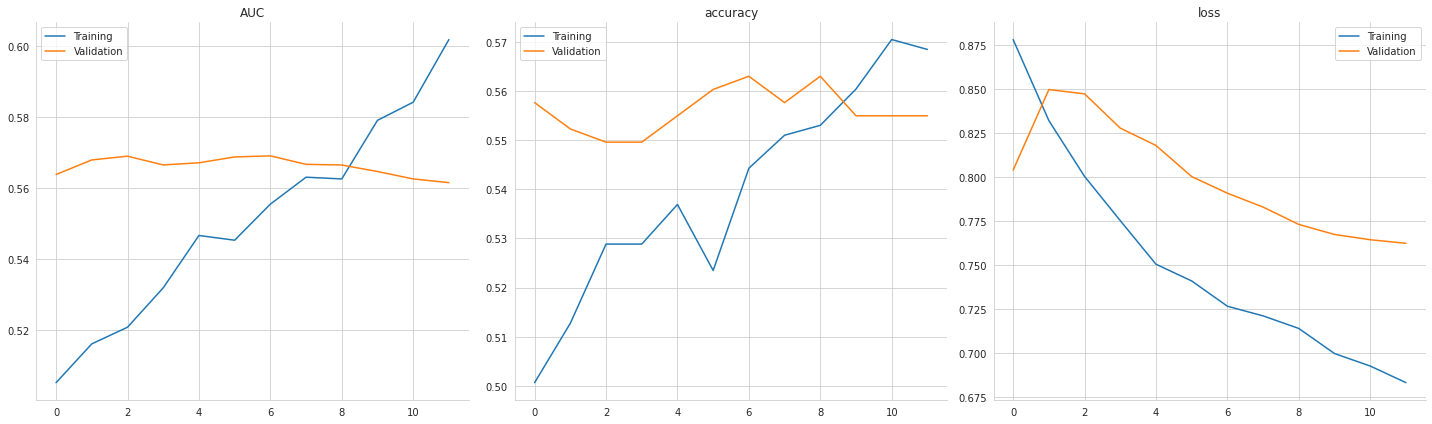

In [203]:
def which_metric(m):
    return m.split('_')[-1]
fig, axes = plt.subplots(ncols=3, figsize=(20,6))
for i, (metric, hist) in enumerate(loss_history.groupby(which_metric, axis=1)):
    hist.plot(ax=axes[i], title=metric)
    axes[i].legend(['Training', 'Validation'])

sns.despine()
fig.tight_layout()
fig.savefig(results_path / 'lstm_stacked_3l_bayes_5438', dpi=300);



### Get the validation set data

In [178]:
val_data = data.loc['2016-04':]  # leave june as out of sample testing

In [179]:
window=60
sequence = list(range(1, window+1))
X_val = [
           val_data.loc[:, sequence].values.reshape(-1, window, 1),  # get first window returns
           val_data.filter(like='topic'),  # get main news topics
        #    val_data.filter(like='sent'),   # sentiment from news
           val_data.filter(like='ind')     # indicators from ts
]
y_val = val_data.Label

# Blocking Window CV performance out of bag

#### Validation *58.68* on CV

In [22]:
model.evaluate(X_val, y_val)  # results/bayes_lstm/bayes_5868.h5 model

3/3 [==============================] - 0s 9ms/step - loss: 0.6981 - accuracy: 0.4769 - AUC: 0.5236


[0.6980962157249451, 0.4769230782985687, 0.5236486196517944]

AUC of 52.36, better than random for bet-sizing.

#### Validation *55.76* on CV

In [64]:
model.evaluate(X_val, y_val)  # reults/bayes_lstm/bayes_5576.h5 model

3/3 [==============================] - 0s 16ms/step - loss: 0.7750 - accuracy: 0.6000 - AUC: 0.5174


[0.7749996185302734, 0.6000000238418579, 0.5173745155334473]

The accuracy achieved gets to 60% and the AUC is of 51.73%. Hence, being better results than random.

# Sliding Window CV performance out of bag

#### Two layer 52.78 AUC

On test-set achieved a 54.404 AUC and 53% acc.

In [152]:
model.evaluate(X_val, y_val)  # results/bayes_lstm/sliding_bayes_2l_5278.h5

3/3 [==============================] - 0s 11ms/step - loss: 0.6820 - accuracy: 0.6000 - AUC: 0.5608


[0.6820434927940369, 0.6000000238418579, 0.5608108043670654]

Best Performing model with a 56.1 AUC and 60% Accuracy.

#### Three layer

In [204]:
model.evaluate(X_val, y_val)  # results/bayes_lstm/sliding_bayes_3l_5438.h5

3/3 [==============================] - 0s 17ms/step - loss: 0.8896 - accuracy: 0.4462 - AUC: 0.4348


[0.8896186947822571, 0.446153849363327, 0.43484553694725037]

Out of bag performance suffers with three layers, it is better with two. Tends to backtest overfit.

#### Always buy method:

In [80]:
(np.ones(len(y_val)) == y_val).sum()/len(y_val)

0.5692307692307692

We would have achieved almost a 57% accuracy, 3% worse than the one we got from our model. 

#### Complete random method

In [99]:
import random
(random.choices([0, 1], k=len(y_val)) == y_val).sum()/len(y_val)

0.46153846153846156

Method gets below 50%, however, on average, we would expect it to be around 50%. (In this case, it would be lower, due to the fact that almost 57% of the values are ones.)